/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-533bc792.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 95.0MB/s]


Using 'cuda:0' to train the Model !
Epoch 1, duration: 132 s, loss: 5.1531, acc: 0.2673
Accuracy of the network on the test images: 10 %
Epoch 2, duration: 127 s, loss: 4.5212, acc: 1.0722
Accuracy of the network on the test images: 22 %
Epoch 3, duration: 126 s, loss: 3.8004, acc: 2.3340
Accuracy of the network on the test images: 37 %
Epoch 4, duration: 127 s, loss: 3.1532, acc: 3.6782
Accuracy of the network on the test images: 50 %
Epoch 5, duration: 126 s, loss: 2.6482, acc: 5.0255
Accuracy of the network on the test images: 60 %
Epoch 6, duration: 125 s, loss: 2.2607, acc: 5.9858
Accuracy of the network on the test images: 67 %
Epoch 7, duration: 130 s, loss: 2.0091, acc: 6.5981
Accuracy of the network on the test images: 69 %
Epoch 8, duration: 126 s, loss: 1.7687, acc: 7.2989
Accuracy of the network on the test images: 72 %
Epoch 9, duration: 126 s, loss: 1.5322, acc: 8.0293
Accuracy of the network on the test images: 76 %
Epoch 10, duration: 126 s, loss: 1.4978, acc: 8.1940
Ac

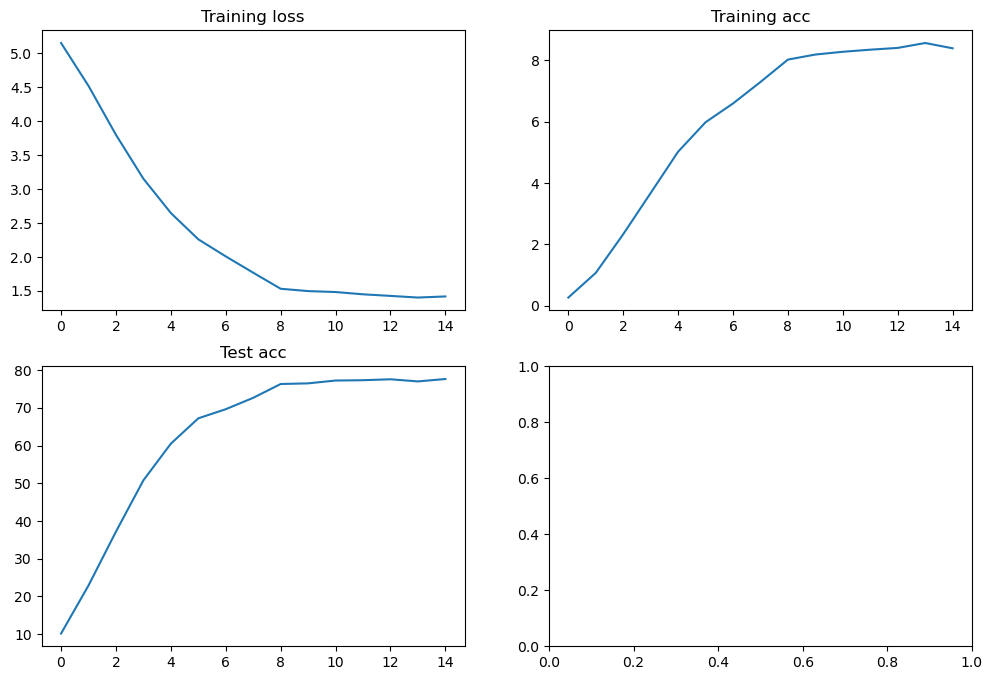

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms

import time

def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    return test_acc

if __name__ == '__main__':

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])

    train_dataset = datasets.ImageFolder(
        root='/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test',
        transform=train_transforms
    )
    val_dataset = datasets.ImageFolder(
        root='/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train',
        transform=val_transforms
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=2
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=2
    )

    model = models.efficientnet_b1(pretrained=True)
    for params in model.parameters():
            params.requires_grad = True
    model.classifier[1] = nn.Linear(in_features=1280, out_features=196)
    #print(model.fc)

    #num_ftrs = model.fc.in_features
    #model.fc = nn.Linear(num_ftrs, 196)

    #print(model.fc)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using '{device}' to train the Model !")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

    model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, lrscheduler, n_epochs=15)
    
    torch.save(model.state_dict(), "./trainedModelFinal.pt")
    
    f, axarr = plt.subplots(2,2, figsize = (12, 8))
    axarr[0, 0].plot(training_losses)
    axarr[0, 0].set_title("Training loss")
    axarr[0, 1].plot(training_accs)
    axarr[0, 1].set_title("Training acc")
    axarr[1, 0].plot(test_accs)

    axarr[1, 0].set_title("Test acc")
    
    model.eval()




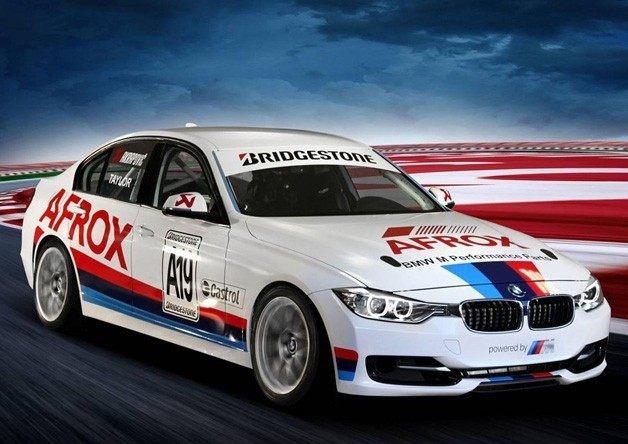

BMW 3 Series Sedan 2012 confidence:  11.1051025390625


In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import PIL.Image as Image
from IPython.display import display

dataset_dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/"
image_to_test_on = "test/BMW 3 Series Sedan 2012/06273.jpg"
model = models.efficientnet_b1(pretrained=True)
for params in model.parameters():
    params.requires_grad = True
model.classifier[1] = nn.Linear(in_features=1280, out_features=196)

classes = ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW Z4 Convertible 2012', 'Bentley Arnage Sedan 2009', 'Bentley Continental Flying Spur Sedan 2007', 'Bentley Continental GT Coupe 2007', 'Bentley Continental GT Coupe 2012', 'Bentley Continental Supersports Conv. Convertible 2012', 'Bentley Mulsanne Sedan 2011', 'Bugatti Veyron 16.4 Convertible 2009', 'Bugatti Veyron 16.4 Coupe 2009', 'Buick Enclave SUV 2012', 'Buick Rainier SUV 2007', 'Buick Regal GS 2012', 'Buick Verano Sedan 2012', 'Cadillac CTS-V Sedan 2012', 'Cadillac Escalade EXT Crew Cab 2007', 'Cadillac SRX SUV 2012', 'Chevrolet Avalanche Crew Cab 2012', 'Chevrolet Camaro Convertible 2012', 'Chevrolet Cobalt SS 2010', 'Chevrolet Corvette Convertible 2012', 'Chevrolet Corvette Ron Fellows Edition Z06 2007', 'Chevrolet Corvette ZR1 2012', 'Chevrolet Express Cargo Van 2007', 'Chevrolet Express Van 2007', 'Chevrolet HHR SS 2010', 'Chevrolet Impala Sedan 2007', 'Chevrolet Malibu Hybrid Sedan 2010', 'Chevrolet Malibu Sedan 2007', 'Chevrolet Monte Carlo Coupe 2007', 'Chevrolet Silverado 1500 Classic Extended Cab 2007', 'Chevrolet Silverado 1500 Extended Cab 2012', 'Chevrolet Silverado 1500 Hybrid Crew Cab 2012', 'Chevrolet Silverado 1500 Regular Cab 2012', 'Chevrolet Silverado 2500HD Regular Cab 2012', 'Chevrolet Sonic Sedan 2012', 'Chevrolet Tahoe Hybrid SUV 2012', 'Chevrolet TrailBlazer SS 2009', 'Chevrolet Traverse SUV 2012', 'Chrysler 300 SRT-8 2010', 'Chrysler Aspen SUV 2009', 'Chrysler Crossfire Convertible 2008', 'Chrysler PT Cruiser Convertible 2008', 'Chrysler Sebring Convertible 2010', 'Chrysler Town and Country Minivan 2012', 'Daewoo Nubira Wagon 2002', 'Dodge Caliber Wagon 2007', 'Dodge Caliber Wagon 2012', 'Dodge Caravan Minivan 1997', 'Dodge Challenger SRT8 2011', 'Dodge Charger SRT-8 2009', 'Dodge Charger Sedan 2012', 'Dodge Dakota Club Cab 2007', 'Dodge Dakota Crew Cab 2010', 'Dodge Durango SUV 2007', 'Dodge Durango SUV 2012', 'Dodge Journey SUV 2012', 'Dodge Magnum Wagon 2008', 'Dodge Ram Pickup 3500 Crew Cab 2010', 'Dodge Ram Pickup 3500 Quad Cab 2009', 'Dodge Sprinter Cargo Van 2009', 'Eagle Talon Hatchback 1998', 'FIAT 500 Abarth 2012', 'FIAT 500 Convertible 2012', 'Ferrari 458 Italia Convertible 2012', 'Ferrari 458 Italia Coupe 2012', 'Ferrari California Convertible 2012', 'Ferrari FF Coupe 2012', 'Fisker Karma Sedan 2012', 'Ford E-Series Wagon Van 2012', 'Ford Edge SUV 2012', 'Ford Expedition EL SUV 2009', 'Ford F-150 Regular Cab 2007', 'Ford F-150 Regular Cab 2012', 'Ford F-450 Super Duty Crew Cab 2012', 'Ford Fiesta Sedan 2012', 'Ford Focus Sedan 2007', 'Ford Freestar Minivan 2007', 'Ford GT Coupe 2006', 'Ford Mustang Convertible 2007', 'Ford Ranger SuperCab 2011', 'GMC Acadia SUV 2012', 'GMC Canyon Extended Cab 2012', 'GMC Savana Van 2012', 'GMC Terrain SUV 2012', 'GMC Yukon Hybrid SUV 2012', 'Geo Metro Convertible 1993', 'HUMMER H2 SUT Crew Cab 2009', 'HUMMER H3T Crew Cab 2010', 'Honda Accord Coupe 2012', 'Honda Accord Sedan 2012', 'Honda Odyssey Minivan 2007', 'Honda Odyssey Minivan 2012', 'Hyundai Accent Sedan 2012', 'Hyundai Azera Sedan 2012', 'Hyundai Elantra Sedan 2007', 'Hyundai Elantra Touring Hatchback 2012', 'Hyundai Genesis Sedan 2012', 'Hyundai Santa Fe SUV 2012', 'Hyundai Sonata Hybrid Sedan 2012', 'Hyundai Sonata Sedan 2012', 'Hyundai Tucson SUV 2012', 'Hyundai Veloster Hatchback 2012', 'Hyundai Veracruz SUV 2012', 'Infiniti G Coupe IPL 2012', 'Infiniti QX56 SUV 2011', 'Isuzu Ascender SUV 2008', 'Jaguar XK XKR 2012', 'Jeep Compass SUV 2012', 'Jeep Grand Cherokee SUV 2012', 'Jeep Liberty SUV 2012', 'Jeep Patriot SUV 2012', 'Jeep Wrangler SUV 2012', 'Lamborghini Aventador Coupe 2012', 'Lamborghini Diablo Coupe 2001', 'Lamborghini Gallardo LP 570-4 Superleggera 2012', 'Lamborghini Reventon Coupe 2008', 'Land Rover LR2 SUV 2012', 'Land Rover Range Rover SUV 2012', 'Lincoln Town Car Sedan 2011', 'MINI Cooper Roadster Convertible 2012', 'Maybach Landaulet Convertible 2012', 'Mazda Tribute SUV 2011', 'McLaren MP4-12C Coupe 2012', 'Mercedes-Benz 300-Class Convertible 1993', 'Mercedes-Benz C-Class Sedan 2012', 'Mercedes-Benz E-Class Sedan 2012', 'Mercedes-Benz S-Class Sedan 2012', 'Mercedes-Benz SL-Class Coupe 2009', 'Mercedes-Benz Sprinter Van 2012', 'Mitsubishi Lancer Sedan 2012', 'Nissan 240SX Coupe 1998', 'Nissan Juke Hatchback 2012', 'Nissan Leaf Hatchback 2012', 'Nissan NV Passenger Van 2012', 'Plymouth Neon Coupe 1999', 'Porsche Panamera Sedan 2012', 'Ram C-V Cargo Van Minivan 2012', 'Rolls-Royce Ghost Sedan 2012', 'Rolls-Royce Phantom Drophead Coupe Convertible 2012', 'Rolls-Royce Phantom Sedan 2012', 'Scion xD Hatchback 2012', 'Spyker C8 Convertible 2009', 'Spyker C8 Coupe 2009', 'Suzuki Aerio Sedan 2007', 'Suzuki Kizashi Sedan 2012', 'Suzuki SX4 Hatchback 2012', 'Suzuki SX4 Sedan 2012', 'Tesla Model S Sedan 2012', 'Toyota 4Runner SUV 2012', 'Toyota Camry Sedan 2012', 'Toyota Corolla Sedan 2012', 'Toyota Sequoia SUV 2012', 'Volkswagen Beetle Hatchback 2012', 'Volkswagen Golf Hatchback 1991', 'Volkswagen Golf Hatchback 2012', 'Volvo 240 Sedan 1993', 'Volvo C30 Hatchback 2012', 'Volvo XC90 SUV 2007', 'smart fortwo Convertible 2012']


#print(model.fc)


model.load_state_dict(torch.load('/kaggle/working/trainedModelFinal.pt'))
model.eval()


loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

image = Image.open(dataset_dir+image_to_test_on)
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
output = model(image)
conf, predicted = torch.max(output.data, 1)


display(Image.open(dataset_dir+image_to_test_on))
print(classes[predicted.item()], "confidence: ", conf.item())